Library 

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import missingno as msno
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn

import warnings
warnings.filterwarnings('ignore')

In [51]:
!pip install xgboost

  Using cached xgboost-1.3.3-py3-none-win_amd64.whl (95.2 MB)


# Import data

In [4]:
# les columns a supprimer
col_exclude = ['Code service CH', 'Reference document', '1 Articles CGI',
               '2 Articles CGI', '3 Articles CGI', '4 Articles CGI', '5 Articles CGI', 'Identifiant local',
               '5eme lot', '4eme lot', '3eme lot', '2eme lot', '1er lot']
# transformer la columne en datetime
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
data_types = {'Code postal':'string',
              'No voie': 'Int64',
              'Surface Carrez du 1er lot':'Float16',
              'Surface Carrez du 2eme lot':'Float16',
              'Surface Carrez du 3eme lot':'Float16',
              'Surface Carrez du 4eme lot':'Float16',
              'Surface Carrez du 5eme lot':'Float16',
              'Nombre de lots':'Int16',
              'Nombre de lots':'Int16',
              'Surface reelle bati': 'Float32',
              'Nombre pieces principales': 'Int8',
              'Surface terrain':'Float32'}
# dtype code postal string
valeur_fonciere_2020 = pd.read_csv('datasets/valeursfoncieres-2020.txt', sep='|', decimal=",", 
                                   parse_dates=['Date mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=lambda col: col not in col_exclude)
valeur_fonciere_2019 = pd.read_csv('datasets/valeursfoncieres-2019.txt', sep='|', decimal=",",
                                   parse_dates=['Date mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=lambda col: col not in col_exclude)
valeur_fonciere_2018 = pd.read_csv('datasets/valeursfoncieres-2018.txt', sep='|', decimal=",",
                                   parse_dates=['Date mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=lambda col: col not in col_exclude)
valeur_fonciere_2017 = pd.read_csv('datasets/valeursfoncieres-2017.txt', sep='|', decimal=",",
                                   parse_dates=['Date mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=lambda col: col not in col_exclude)
valeur_fonciere_2016 = pd.read_csv('datasets/valeursfoncieres-2016.txt', sep='|', decimal=",",
                                   parse_dates=['Date mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=lambda col: col not in col_exclude)
valeur_fonciere_2015 = pd.read_csv('datasets/valeursfoncieres-2015-s2.txt', sep='|', decimal=",",
                                   parse_dates=['Date mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=lambda col: col not in col_exclude)

C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (18,23,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (14,18,23,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Importer les donnee avec géolocolisation

In [5]:
valeur_fonciere_geo_2020 = pd.read_csv('datasets/full2020.csv', sep=',')

C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10,12,17,18,20,22,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
print(valeur_fonciere_geo_2020.columns)
valeur_fonciere_geo_2020.head()

Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2020-1,2020-01-07,1,Vente,8000.0,NaN,NaN,FORTUNAT,B063,1250.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,1061.0,5.323522,46.171899
1,2020-2,2020-01-07,1,Vente,75000.0,NaN,NaN,RUE DE LA CHARTREUSE,0064,1960.0,...,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,610.0,5.226197,46.184538
2,2020-3,2020-01-14,1,Vente,89000.0,NaN,NaN,VACAGNOLE,B112,1340.0,...,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,600.0,NaN,NaN
3,2020-3,2020-01-14,1,Vente,89000.0,NaN,NaN,VACAGNOLE,B112,1340.0,...,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,491.0,NaN,NaN
4,2020-4,2020-01-22,1,Vente,209950.0,11.0,NaN,RUE REYER,3340,1000.0,...,Maison,78.0,5.0,S,sols,NaN,NaN,242.0,5.219902,46.196484


In [7]:
# les columns a supprimer
col_include = ['date_mutation', 'nature_mutation', 'valeur_fonciere',
               'adresse_numero',  'code_postal', 'code_commune', 'nom_commune',
               'code_departement', 'nombre_lots', 'code_type_local', 'type_local', 'surface_reelle_bati',
               'nombre_pieces_principales','surface_terrain']
# transformer la columne en datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
data_types = {'code_postal':'string',
              'adresse_numero': 'Int64',
              'nombre_lots':'Int16',
              'surface_reelle_bati': 'Float32',
              'nombre_pieces_principales': 'Int8',
              'surface_terrain':'Float32',
              'code_commune':'object'}
# dtype code postal string
valeur_fonciere_geo_2020 = pd.read_csv('datasets/full2020.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2019 = pd.read_csv('datasets/full2019.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2018 = pd.read_csv('datasets/full2018.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2017 = pd.read_csv('datasets/full2017.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2016 = pd.read_csv('datasets/full2016.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)
valeur_fonciere_geo_2015 = pd.read_csv('datasets/full2015.csv', sep=",", 
                                   parse_dates=['date_mutation'], date_parser=dateparse, 
                                   dtype=data_types,usecols=col_include)

C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
frames = [valeur_fonciere_2020, valeur_fonciere_2019, valeur_fonciere_2018, valeur_fonciere_2017
         , valeur_fonciere_2016, valeur_fonciere_2015]
df_foncier = pd.concat(frames)

In [69]:
frames_geo = [valeur_fonciere_geo_2020, valeur_fonciere_geo_2019, valeur_fonciere_geo_2018, 
              valeur_fonciere_geo_2017, valeur_fonciere_geo_2016, valeur_fonciere_geo_2015]
df_geo_foncier = pd.concat(frames_geo)

In [70]:
df_geo_foncier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16359982 entries, 0 to 2750304
Data columns (total 14 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   date_mutation              datetime64[ns]
 1   nature_mutation            object        
 2   valeur_fonciere            float64       
 3   adresse_numero             Int64         
 4   code_postal                string        
 5   code_commune               object        
 6   nom_commune                object        
 7   code_departement           object        
 8   nombre_lots                Int16         
 9   code_type_local            float64       
 10  type_local                 object        
 11  surface_reelle_bati        Float32       
 12  nombre_pieces_principales  Int8          
 13  surface_terrain            Float32       
dtypes: Float32(2), Int16(1), Int64(1), Int8(1), datetime64[ns](1), float64(2), object(5), string(1)
memory usage: 1.6+ GB


Recherche des doublons

In [71]:
# Drop duplicates
initial_length = len(df_geo_foncier)
df_geo_foncier.drop_duplicates(inplace=True)
print("Suppression des doublons: {}".format(initial_length-len(df_geo_foncier)))

Suppression des doublons: 1639201


supprimer les transactions repetees

In [72]:
print('origine',len(df_geo_foncier.index))
df_geo_foncier = df_geo_foncier.groupby(['date_mutation','valeur_fonciere']).filter(lambda x: len(x) == 1)
print('apres',len(df_geo_foncier.index))

origine 14720781
apres 1009960


Construire la dataframe de maison et appartement

In [73]:
# df_MA = maison + appartment
df_geo_foncier.rename(columns={'code_commune':'Code INSEE'}, inplace=True)
df_MA = df_geo_foncier[(df_geo_foncier['type_local'].isin(['Maison','Appartement']))&(df_geo_foncier['nature_mutation']=='Vente')]

df_MA.head()

,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,code_postal,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain
4,2020-01-22,Vente,209950.0,11,01000,01053,Bourg-en-Bresse,1,0,1.0,Maison,78.0,5,242.0
9,2020-01-16,Vente,207170.0,10,01000,01053,Bourg-en-Bresse,1,1,1.0,Maison,106.0,4,<NA>
20,2020-01-30,Vente,164650.0,37,01000,01053,Bourg-en-Bresse,1,0,1.0,Maison,90.0,4,212.0
44,2020-01-16,Vente,167490.0,5065,01340,01229,Malafretaz,1,0,1.0,Maison,160.0,5,1278.0
63,2020-01-13,Vente,153248.0,1671,01290,01334,Saint-André-d'Huiriat,1,0,1.0,Maison,203.0,6,1673.0


# Clean data

Présentation statistique les pourcentage des vides

In [74]:
# Missing assessment function 
def missing_values_assessment(df):
    nan_values = df.isnull().sum().sum()
    print('Nombre d\'observations: {:,}'.format(len(df.index)))
    print('Nombre de valeurs: {:,}'.format(df.size))
    print('Valeurs manquantes: {:,}'.format(nan_values))
    print('Qualité des données: {}%'.format(100-round((nan_values/df.size)*100,2)))
    print('Type de données:\n {}%'.format(df.dtypes.value_counts()))
    analysis = {'Manquant': df.isnull().sum(),
                'Manquant %':round((df.isnull().sum()/len(df))*100, 2),
                'Type':df.dtypes
               }
    return pd.DataFrame(analysis)

In [75]:
missing_values_assessment(df_MA).sort_values('Manquant %', ascending=False)

Nombre d'observations: 531,070
Nombre de valeurs: 7,434,980
Valeurs manquantes: 244,803
Qualité des données: 96.71%
Type de données:
 object            5
float64           2
Float32           2
string            1
Int64             1
Int16             1
datetime64[ns]    1
Int8              1
dtype: int64%


,Manquant,Manquant %,Type
surface_terrain,241090,45.40,Float32
adresse_numero,3460,0.65,Int64
code_postal,235,0.04,string
date_mutation,0,0.00,datetime64[ns]
nature_mutation,0,0.00,object
valeur_fonciere,0,0.00,float64
Code INSEE,0,0.00,object
nom_commune,0,0.00,object
code_departement,0,0.00,object
nombre_lots,0,0.00,Int16


Supprimer les columns vides

<AxesSubplot:>

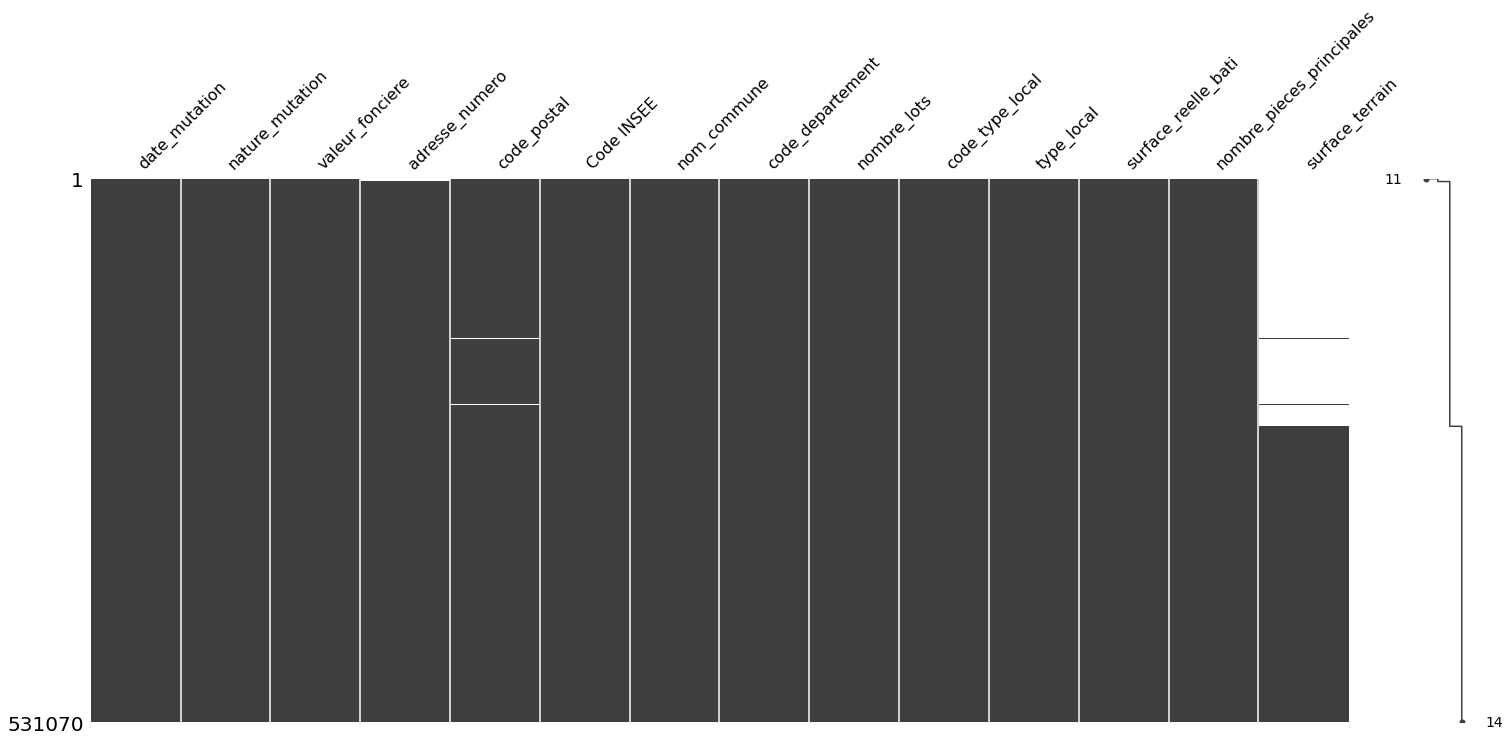

In [76]:
import missingno as msno
msno.matrix(df_MA, sort='ascending')

In [77]:
df_MA['surface_terrain'].fillna(df_MA['surface_reelle_bati'], inplace=True)


C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\pandas\core\series.py:4433: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


<AxesSubplot:>

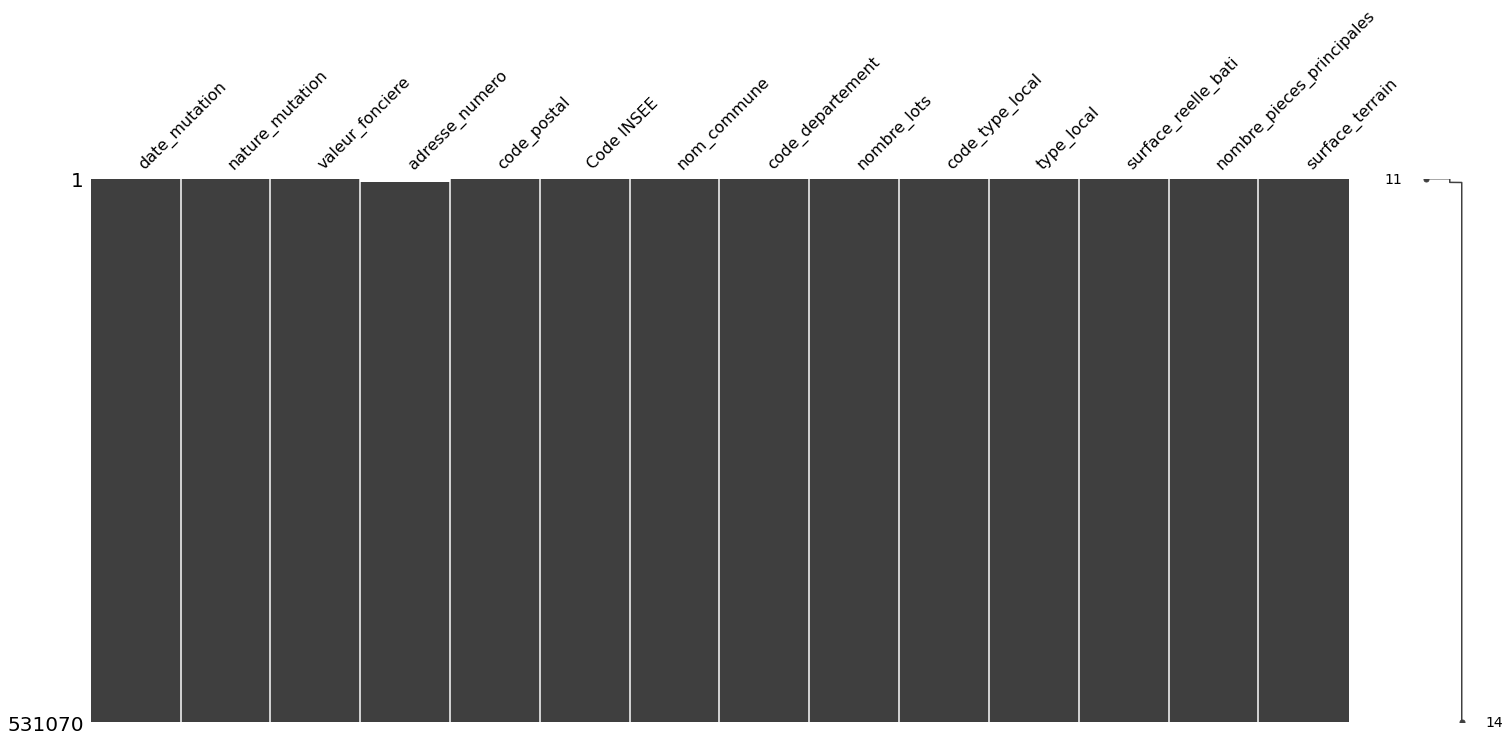

In [78]:
import missingno as msno
msno.matrix(df_MA, sort='ascending')

**Imputation**

In [81]:
df_MA.dropna(how='any', axis=0, inplace=True)

<ipython-input-81-136c1eddf08a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MA.dropna(how='any', axis=0, inplace=True)


Ajouter les columns Years et Months

In [82]:
df_MA['Year'] = pd.DatetimeIndex(df_MA['date_mutation']).year
df_MA['Month'] = pd.DatetimeIndex(df_MA['date_mutation']).month

<ipython-input-82-0f9b15301ea6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MA['Year'] = pd.DatetimeIndex(df_MA['date_mutation']).year
<ipython-input-82-0f9b15301ea6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MA['Month'] = pd.DatetimeIndex(df_MA['date_mutation']).month


In [83]:
df_MA['Prix_m2']=df_MA['valeur_fonciere']/df_MA['surface_reelle_bati']

<ipython-input-83-56450c4c6bbc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MA['Prix_m2']=df_MA['valeur_fonciere']/df_MA['surface_reelle_bati']


In [84]:
df_MA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 527366 entries, 4 to 2750297
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date_mutation              527366 non-null  datetime64[ns]
 1   nature_mutation            527366 non-null  object        
 2   valeur_fonciere            527366 non-null  float64       
 3   adresse_numero             527366 non-null  Int64         
 4   code_postal                527366 non-null  string        
 5   Code INSEE                 527366 non-null  object        
 6   nom_commune                527366 non-null  object        
 7   code_departement           527366 non-null  object        
 8   nombre_lots                527366 non-null  Int16         
 9   code_type_local            527366 non-null  float64       
 10  type_local                 527366 non-null  object        
 11  surface_reelle_bati        527366 non-null  Float32

Export the data

In [21]:
df_MA.to_csv(r'datasets/fonciere_geo.csv', index = None, header=True)

# EDA

In [85]:
df_MA['code_departement'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21,
       22, 23, 24, 25, 26, 27, 28, '28', '29', '2A', '30', 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 69, 70,
       71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 971, 972, 973, 974, 75, 15, 29, '2B'],
      dtype=object)

In [86]:
df_MA_IDF=df_MA[(df_MA['code_departement'].isin([75,91,92,93,94,95,77,78]))]
df_MA_IDF.head()

,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,code_postal,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,Year,Month,Prix_m2
573719,2020-01-06,Vente,257000.0,17,77170,77450,Servon,77,1,1.0,Maison,107.0,5,107.0,2020,1,2401.869159
573720,2020-01-02,Vente,320500.0,15,77380,77122,Combs-la-Ville,77,0,1.0,Maison,85.0,5,347.0,2020,1,3770.588235
573723,2020-01-08,Vente,386700.0,20,77170,77053,Brie-Comte-Robert,77,0,1.0,Maison,129.0,6,507.0,2020,1,2997.674419
573728,2020-01-09,Vente,349000.0,55,77310,77040,Boissise-le-Roi,77,0,1.0,Maison,122.0,4,854.0,2020,1,2860.655738
573756,2020-01-07,Vente,608974.0,42,77310,77407,Saint-Fargeau-Ponthierry,77,0,1.0,Maison,172.0,6,2103.0,2020,1,3540.546512


Distribution Valeur Fonciere

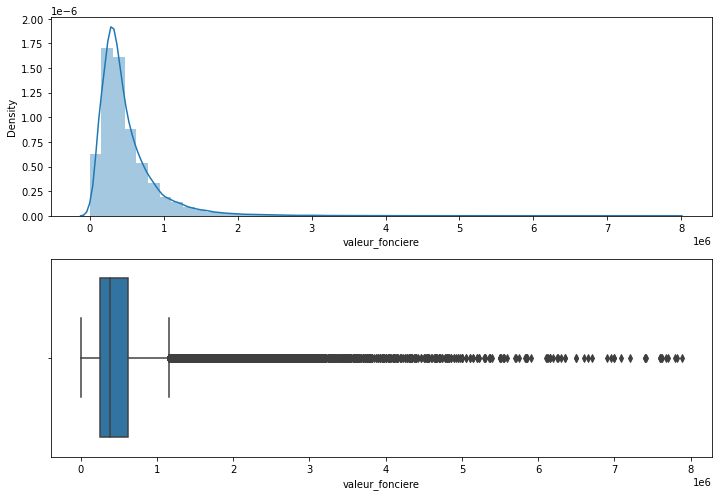

In [329]:
#visualizing valeur_fonciere
fig = plt.figure(figsize=(10,7))
fig.add_subplot(2,1,1)
sns.distplot(df_MA_IDF[df_MA_IDF['valeur_fonciere']<8000000]['valeur_fonciere'])
fig.add_subplot(2,1,2)
sns.boxplot(df_MA_IDF[df_MA_IDF['valeur_fonciere']<8000000]['valeur_fonciere'])
plt.tight_layout()

Etude corrélation des features

<AxesSubplot:>

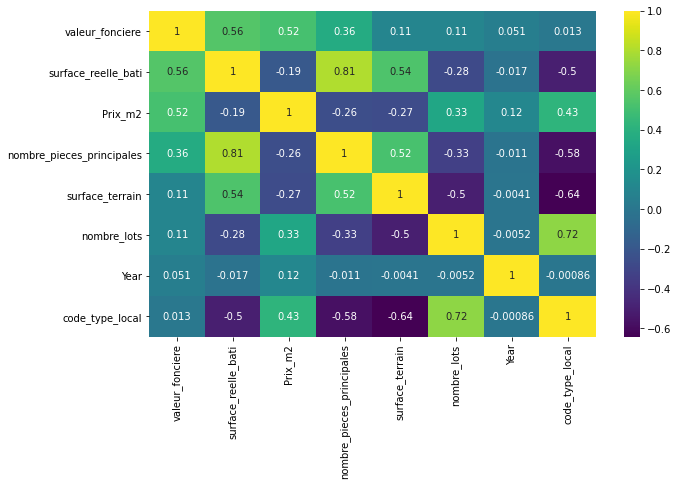

In [87]:
#Quality correlation matrix
k = 8 #number of variables for heatmap
cols = df_MA_IDF.corr().nlargest(k, 'valeur_fonciere')['valeur_fonciere'].index
cm = df_MA_IDF[cols].corr() 
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

<AxesSubplot:xlabel='surface_terrain', ylabel='valeur_fonciere'>

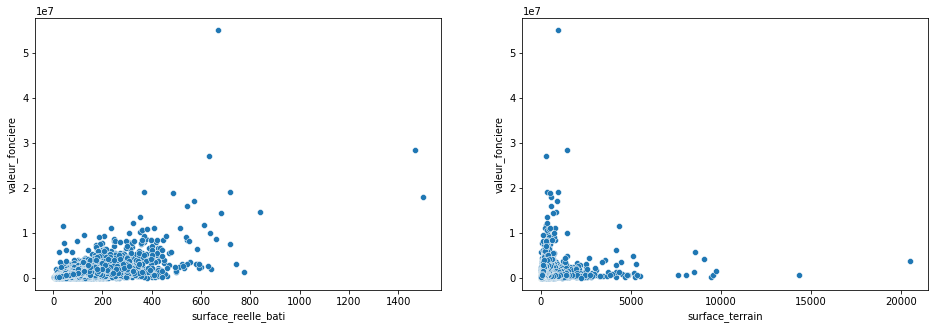

In [337]:

fig = plt.figure(figsize=(16,5))
fig.add_subplot(1,2,1)
sns.scatterplot(df_MA_IDF['surface_reelle_bati'], df_MA_IDF['valeur_fonciere'])
fig.add_subplot(1,2,2)
sns.scatterplot(df_MA_IDF['surface_terrain'],df_MA_IDF['valeur_fonciere'])

<AxesSubplot:xlabel='nombre_pieces_principales', ylabel='count'>

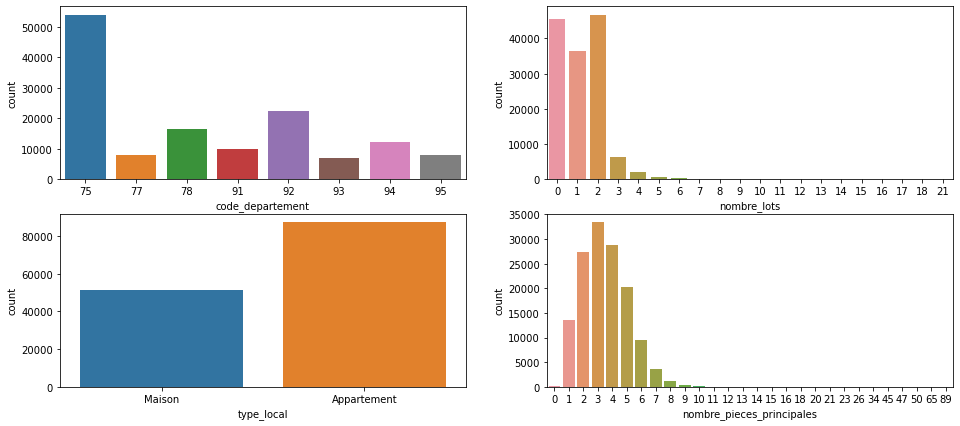

In [334]:


fig = plt.figure(figsize=(16,7))
fig.add_subplot(2,2,1)
sns.countplot(df_MA_IDF['code_departement'])
fig.add_subplot(2,2,2)
sns.countplot(df_MA_IDF['nombre_lots'])
fig.add_subplot(2,2,3)
sns.countplot(df_MA_IDF['type_local'])
fig.add_subplot(2,2,4)
sns.countplot(df_MA_IDF['nombre_pieces_principales'])

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10) , gridspec_kw={'hspace': 0.5})

Mutation par Mois

Text(0, 0.5, 'Nombre de mutation')

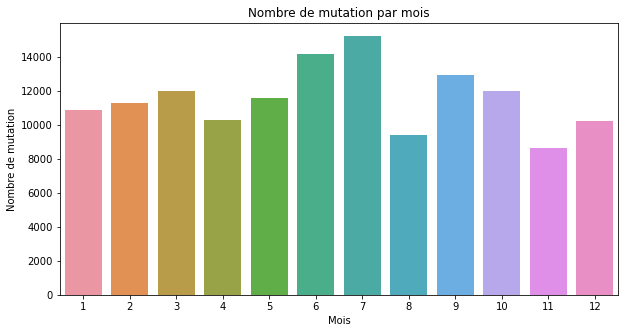

In [89]:

plt.figure(figsize=(10,5))
ax = sns.countplot(x=df_MA_IDF.Month)
ax.set_title('Nombre de mutation par mois')
ax.set_xlabel('Mois')
ax.set_ylabel('Nombre de mutation')

<ipython-input-90-21168a352fac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MA_IDF['jour_de_semaine'] = df_MA_IDF['date_mutation'].map(lambda x: x.dayofweek)


Text(0, 0.5, 'Nombre de mutation')

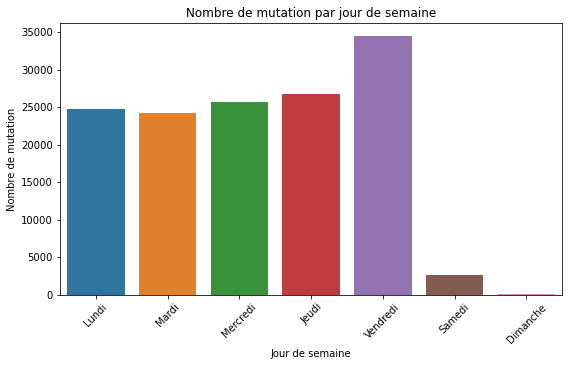

In [90]:
plt.figure(figsize=(9,5))
df_MA_IDF['jour_de_semaine'] = df_MA_IDF['date_mutation'].map(lambda x: x.dayofweek)
ax = sns.countplot(x=df_MA_IDF['jour_de_semaine'])
ax.set_title('Nombre de mutation par jour de semaine')
ax.set_xlabel('Jour de semaine')
ax.set_xticklabels(['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche'],rotation=45)
ax.set_ylabel('Nombre de mutation')

Detect the outliers

In [102]:
print('The "Surface terrain" where we reach the 90th/10th quantile is :',
      df_MA_IDF['surface_terrain'].quantile(q=0.95),df_MA_IDF['surface_terrain'].quantile(q=0.10),'m2',
      '\n',
      'The "Surface reelle bati" where we reach the 95th quantile is :',
      df_MA_IDF['surface_reelle_bati'].quantile(q=0.95),'m2',
      '\n',
     'The "Nombre pieces principales" where we reach the 99,95th quantile is :',
      df_MA_IDF['nombre_pieces_principales'].quantile(q=0.9995),'piece',
     '\n',
     'The "Valeur fonciere" where we reach the 99,95th quantile is :',
      df_MA_IDF['valeur_fonciere'].quantile(q=0.8),'euros')

The "Surface terrain" where we reach the 90th/10th quantile is : 619.0 30.0 m2 
 The "Surface reelle bati" where we reach the 95th quantile is : 162.0 m2 
 The "Nombre pieces principales" where we reach the 99,95th quantile is : 11.0 piece 
 The "Valeur fonciere" where we reach the 99,95th quantile is : 695000.0 euros


{'whiskers': [<matplotlib.lines.Line2D at 0x2e224b31730>,
 'caps': [<matplotlib.lines.Line2D at 0x2e224b407f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e224b21e20>],
 'medians': [<matplotlib.lines.Line2D at 0x2e224b5fd90>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e224b5f190>],
 'means': []}

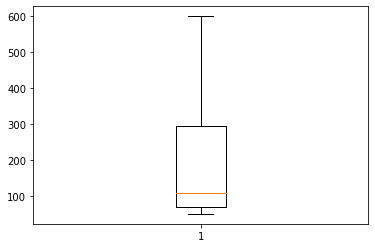

In [104]:
df_test = df_MA_IDF[(df_MA_IDF['surface_terrain']<600.0)&(df_MA_IDF['surface_terrain']>50.0)]
plt.boxplot(df_test['surface_terrain'])


{'whiskers': [<matplotlib.lines.Line2D at 0x2e224f83e20>,
 'caps': [<matplotlib.lines.Line2D at 0x2e224f936d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e224f746a0>],
 'medians': [<matplotlib.lines.Line2D at 0x2e224fa21f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e224fb28b0>],
 'means': []}

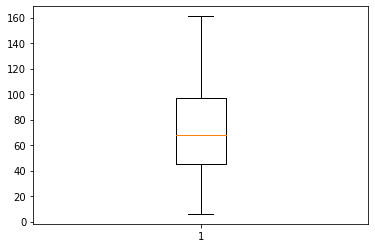

In [105]:
df_test = df_MA_IDF[(df_MA_IDF['surface_reelle_bati']<162)&(df_MA_IDF['surface_reelle_bati']>5)]
plt.boxplot(df_test['surface_reelle_bati'])

Outliers pour Nombre pieces principales

{'whiskers': [<matplotlib.lines.Line2D at 0x2e2303adbe0>,
 'caps': [<matplotlib.lines.Line2D at 0x2e2303bc700>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e23039f4c0>],
 'medians': [<matplotlib.lines.Line2D at 0x2e2303cb580>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e2303dbc40>],
 'means': []}

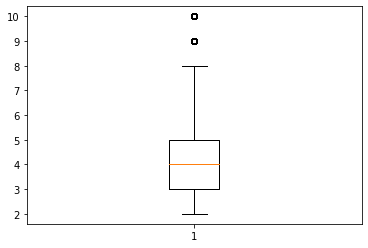

In [106]:
df_test = df_MA_IDF[(df_MA_IDF['nombre_pieces_principales']<11)&(df_MA_IDF['nombre_pieces_principales']>1)]
plt.boxplot(df_test['nombre_pieces_principales'])

{'whiskers': [<matplotlib.lines.Line2D at 0x2e230547280>,
 'caps': [<matplotlib.lines.Line2D at 0x2e230556910>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e230538f40>],
 'medians': [<matplotlib.lines.Line2D at 0x2e230574be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e230574490>],
 'means': []}

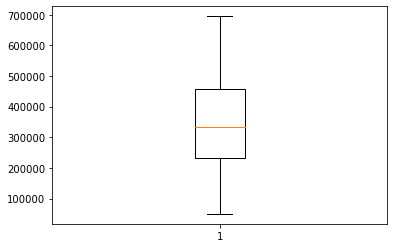

In [107]:
df_test = df_MA_IDF[(df_MA_IDF['valeur_fonciere']<695000)&(df_MA_IDF['valeur_fonciere']>50000)]
plt.boxplot(df_test['valeur_fonciere'])

Construire le dataframe final

The "Surface terrain" where we reach the 90th/10th quantile is : 702.0 159.0 m2 
 The "Surface reelle bati" where we reach the 95th quantile is : 185.0 m2 
 The "Nombre pieces principales" where we reach the 99,95th quantile is : 13.0 piece 
 The "Valeur fonciere" where we reach the 99,95th quantile is : 655119.9999999998 euros

In [108]:
df_fonciere_final = df_MA_IDF[(df_MA_IDF['valeur_fonciere']<695000)&(df_MA_IDF['valeur_fonciere']>50000)&
                     (df_MA_IDF['nombre_pieces_principales']<11)&(df_MA_IDF['nombre_pieces_principales']>1)&
                       (df_MA_IDF['surface_terrain']<600)&(df_MA_IDF['surface_terrain']>50)&
                     (df_MA_IDF['surface_reelle_bati']<162)&(df_MA_IDF['surface_reelle_bati']>5)]

df_fonciere_final.head()

,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,code_postal,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,Year,Month,Prix_m2,jour_de_semaine
573719,2020-01-06,Vente,257000.0,17,77170,77450,Servon,77,1,1.0,Maison,107.0,5,107.0,2020,1,2401.869159,0
573720,2020-01-02,Vente,320500.0,15,77380,77122,Combs-la-Ville,77,0,1.0,Maison,85.0,5,347.0,2020,1,3770.588235,3
573723,2020-01-08,Vente,386700.0,20,77170,77053,Brie-Comte-Robert,77,0,1.0,Maison,129.0,6,507.0,2020,1,2997.674419,2
573765,2020-01-09,Vente,239900.0,1,77380,77122,Combs-la-Ville,77,0,1.0,Maison,79.0,4,138.0,2020,1,3036.708861,3
573790,2020-01-02,Vente,356900.0,1,77127,77251,Lieusaint,77,0,1.0,Maison,110.0,5,404.0,2020,1,3244.545455,3


In [109]:
df_fonciere_final.drop(['date_mutation','nature_mutation','code_postal','type_local'],axis = 1, inplace = True)

C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [110]:
df_fonciere_final.head()

,valeur_fonciere,adresse_numero,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,Year,Month,Prix_m2,jour_de_semaine
573719,257000.0,17,77450,Servon,77,1,1.0,107.0,5,107.0,2020,1,2401.869159,0
573720,320500.0,15,77122,Combs-la-Ville,77,0,1.0,85.0,5,347.0,2020,1,3770.588235,3
573723,386700.0,20,77053,Brie-Comte-Robert,77,0,1.0,129.0,6,507.0,2020,1,2997.674419,2
573765,239900.0,1,77122,Combs-la-Ville,77,0,1.0,79.0,4,138.0,2020,1,3036.708861,3
573790,356900.0,1,77251,Lieusaint,77,0,1.0,110.0,5,404.0,2020,1,3244.545455,3


Concat data popu 

In [111]:
all_data=pd.read_csv('datasets/all_dataset.csv')
all_data.head()

C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Code INSEE,nom_comm,code_dept,code_reg,superficie_km2,lat,lng,age_mean,age_std,age_median,population,merge1,Foyer,Nbr_p_Foyer,revenue_median,revenue_inequalities,merge2,density
0,91645,VERRIERES-LE-BUISSON,91.0,11.0,9.99,48.750443,2.251713,43.180904,25.055513,46.0,15434.0,both,6224.0,15843.0,34210.0,4.2,both,1544.944945
1,77133,COURCELLES-EN-BASSEE,77.0,11.0,10.82,48.412561,3.052941,46.291262,22.518442,51.0,219.0,both,89.0,217.0,25610.0,NaN,both,20.240296
2,91378,MAUCHAMPS,91.0,11.0,3.13,48.527268,2.197182,40.643885,22.728120,44.0,273.0,both,102.0,283.0,28080.0,NaN,both,87.220447
3,77243,LAGNY-SUR-MARNE,77.0,11.0,5.79,48.873070,2.709781,38.360069,23.270647,38.0,21264.0,both,9047.0,21301.0,23290.0,3.5,both,3672.538860
4,94003,ARCUEIL,94.0,11.0,2.32,48.805880,2.333510,37.410927,22.696750,36.0,21567.0,both,8811.0,20197.0,21750.0,4.0,both,9296.120690


In [112]:
#test_df = df_final[df_final['Code INSEE']=='94003']

df_merged = pd.merge(df_fonciere_final,all_data,on='Code INSEE',how='left', indicator=True)
df_merged.head()

,valeur_fonciere,adresse_numero,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,...,age_median,population,merge1,Foyer,Nbr_p_Foyer,revenue_median,revenue_inequalities,merge2,density,_merge
0,257000.0,17,77450,Servon,77,1,1.0,107.0,5,107.0,...,40.0,3233.0,both,1225.0,3328.0,28500.0,2.8,both,438.075881,both
1,320500.0,15,77122,Combs-la-Ville,77,0,1.0,85.0,5,347.0,...,37.0,22212.0,both,8368.0,22173.0,23470.0,3.1,both,1525.549451,both
2,386700.0,20,77053,Brie-Comte-Robert,77,0,1.0,129.0,6,507.0,...,36.0,17200.0,both,7468.0,17477.0,23290.0,3.0,both,863.453815,both
3,239900.0,1,77122,Combs-la-Ville,77,0,1.0,79.0,4,138.0,...,37.0,22212.0,both,8368.0,22173.0,23470.0,3.1,both,1525.549451,both
4,356900.0,1,77251,Lieusaint,77,0,1.0,110.0,5,404.0,...,29.0,13363.0,both,4546.0,12673.0,22200.0,2.8,both,1121.998321,both


In [113]:
df_merged[df_merged['code_departement']==75]

,valeur_fonciere,adresse_numero,Code INSEE,nom_commune,code_departement,nombre_lots,code_type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,...,age_median,population,merge1,Foyer,Nbr_p_Foyer,revenue_median,revenue_inequalities,merge2,density,_merge
4331,544000.0,35,75101,Paris 1er Arrondissement,75,1,2.0,52.0,2,52.0,...,40.0,16252.0,both,8533.0,15560.0,32890.0,7.2,both,8979.005525,both
4332,605000.0,21,75108,Paris 8e Arrondissement,75,2,2.0,61.0,3,61.0,...,38.0,36453.0,both,17387.0,37343.0,41270.0,8.6,both,9468.311688,both
4333,632000.0,10,75101,Paris 1er Arrondissement,75,1,2.0,103.0,3,103.0,...,40.0,16252.0,both,8533.0,15560.0,32890.0,7.2,both,8979.005525,both
4334,625000.0,119,75101,Paris 1er Arrondissement,75,1,2.0,52.0,3,52.0,...,40.0,16252.0,both,8533.0,15560.0,32890.0,7.2,both,8979.005525,both
4335,51875.0,53,75108,Paris 8e Arrondissement,75,4,2.0,118.0,3,118.0,...,38.0,36453.0,both,17387.0,37343.0,41270.0,8.6,both,9468.311688,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62951,510000.0,113,75104,Paris 4e Arrondissement,75,3,2.0,52.0,2,52.0,...,39.0,27487.0,both,14043.0,25626.0,31200.0,6.7,both,17179.375000,both
62952,504000.0,2,75104,Paris 4e Arrondissement,75,2,2.0,58.0,3,58.0,...,39.0,27487.0,both,14043.0,25626.0,31200.0,6.7,both,17179.375000,both
62953,613000.0,10,75102,Paris 2e Arrondissement,75,2,2.0,55.0,2,55.0,...,35.0,20260.0,both,11557.0,20803.0,31470.0,7.1,both,20464.646465,both
62954,507850.0,199,75102,Paris 2e Arrondissement,75,2,2.0,64.0,3,64.0,...,35.0,20260.0,both,11557.0,20803.0,31470.0,7.1,both,20464.646465,both


C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

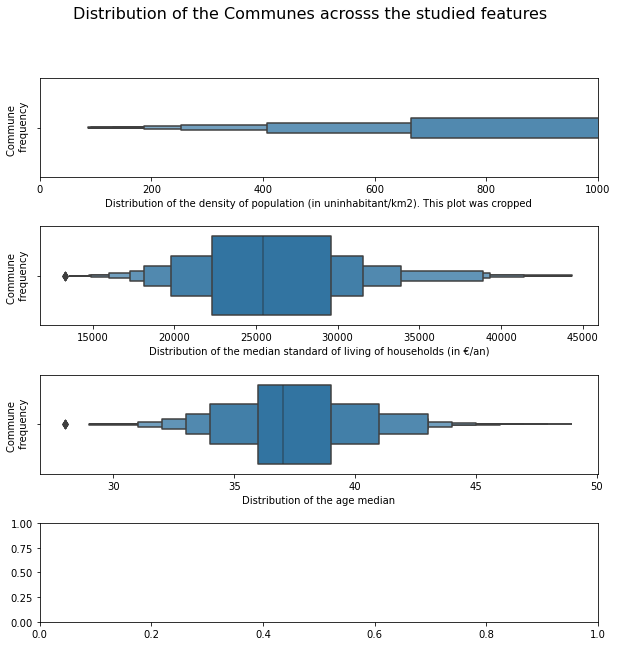

In [208]:
# Define subplots object
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,10) , gridspec_kw={'hspace': 0.5})

fig.suptitle('Distribution of the Communes acrosss the studied features', fontsize=16)

# Plot density
sns.boxenplot(df_merged['density'],ax=ax1)
ax1.set_xlabel('Distribution of the density of population (in uninhabitant/km2). This plot was cropped')
ax1.set_ylabel('Commune \n frequency')
ax1.set_xlim(0,1000)

# Plot revenue_median
sns.boxenplot(df_merged['revenue_median'],ax=ax2)
ax2.set_xlabel('Distribution of the median standard of living of households (in €/an)')
ax2.set_ylabel('Commune \n frequency')

# Plot age_median
sns.boxenplot(df_merged['age_median'],ax=ax3)
ax3.set_xlabel('Distribution of the age median')
ax3.set_ylabel('Commune \n frequency')

# Plot Prix_m2
sns.boxenplot(df_merged['Prix_m2'],ax=ax4)
ax4.set_xlabel('Distribution of the mean price of houses per m2 ( in €/m2). This plot was cropped ')
ax4.set_ylabel('Commune \n frequency')
ax4.set_xlim(0,6000)

In [115]:
print(df_merged.shape)

(62956, 32)


In [116]:
print(df_merged.shape)
df_merged.dropna(how='any', axis=0, inplace=True)
print(df_merged.shape)

(62956, 32)
(61224, 32)


In [117]:
df_merged.to_csv('datasets/df_merged_dataset.csv', index=False)

**Encode**

In [118]:
df_merged.columns

Index(['valeur_fonciere', 'adresse_numero', 'Code INSEE', 'nom_commune',
       'code_departement', 'nombre_lots', 'code_type_local',
       'surface_reelle_bati', 'nombre_pieces_principales', 'surface_terrain',
       'Year', 'Month', 'Prix_m2', 'jour_de_semaine', 'nom_comm', 'code_dept',
       'code_reg', 'superficie_km2', 'lat', 'lng', 'age_mean', 'age_std',
       'age_median', 'population', 'merge1', 'Foyer', 'Nbr_p_Foyer',
       'revenue_median', 'revenue_inequalities', 'merge2', 'density',
       '_merge'],
      dtype='object')

# Machine learning

Dataset Preparation (Splitting and Scaling)

In [211]:
from sklearn.model_selection import train_test_split

numeric_features = ['nombre_lots','surface_reelle_bati','nombre_pieces_principales','surface_terrain','superficie_km2',
                    'age_median','revenue_median','population','density']
categorical_features = ['adresse_numero','code_type_local','Month','code_departement']

col_X = numeric_features+categorical_features

X = df_merged[col_X].values
y = df_merged['valeur_fonciere'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [156]:
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

LinearRegression

In [277]:
# Multiple Liner Regression
from sklearn.linear_model import LinearRegression
model_regressor = LinearRegression()  
model_regressor.fit(X_train, y_train)

#evaluate the model (intercept and slope)
print(regressor.intercept_)
print(regressor.coef_)

#predicting the test set result
y_pred_model1 = model_regressor.predict(X_test)


389128.36400648445
[  3497.30338554  48945.19614355  -5071.6817572    6603.82293599
   3794.03271106  -3893.64326644  70736.71902169  40053.9908556
  80291.29527865  -3535.4961149  -43389.61246607    897.01584355
   7701.30393134]


In [279]:
print("model R2 score: %.3f" % model_regressor.score(X_test, y_test))

from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, y_pred_model1)
print('model regressor MSE is: ', MSE)


model R2 score: 0.533
model regressor MSE is:  10849682314.1255


In [298]:
#score collector
score_data = {'Model':['LinearRegression'],'R2':[model_regressor.score(X_test, y_test)],'MSE':[MSE]}
score_collector = pd.DataFrame(score_data)
score_collector

,Model,R2,MSE
0,LinearRegression,0.533473,1.084968e+10


C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

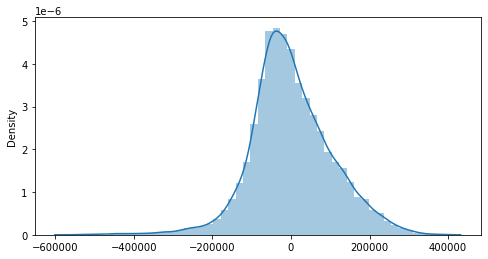

In [165]:
# visualizing residuals
fig = plt.figure(figsize=(8,4))
residuals = (y_test- y_pred_model1)
sns.distplot(residuals)

Ensemble Learning -Boosting -Xgboost

In [170]:
import xgboost as xgb 

model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 200, verbosity=1)

model_xgb.fit(X_train, y_train)
print("model score: %.3f" % model_xgb.score(X_test, y_test))

model score: 0.694


XGBoosting with GridSearch

In [184]:
from sklearn.model_selection import GridSearchCV

# Round 1 Grid search for n_estimators
xgb_model_r1 = xgb.XGBRegressor(max_depth=5,learning_rate= 0.1, verbosity=1, 
                              objective='reg:squarederror',random_state=1)

grid_r1= GridSearchCV(xgb_model_r1, {'n_estimators': [20,50,100,150,200]}, scoring='neg_mean_squared_error', cv=10)
grid_r1.fit(X_train,y_train)

#get the best score and parameters

print(grid_r1.best_score_)
print(grid_r1.best_params_)



-7138568635.188904
{'n_estimators': 200}


In [186]:
# Round 2 Grid search for max_depth and min_child_weight
xgb_model_r2 = xgb.XGBRegressor(n_estimators=200, learning_rate= 0.1, verbosity=1,
                                 objective='reg:squarederror',random_state=1)
param_r2 = {
 'max_depth':range(3,12,1),
 'min_child_weight':range(1,6,2)}

grid_r2= GridSearchCV(xgb_model_r2, param_grid = param_r2, scoring='neg_mean_squared_error', cv=10)
grid_r2.fit(X_train,y_train)

#get the best score and parameters
print(grid_r2.best_score_)
print(grid_r2.best_params_)

-7025000191.570776
{'max_depth': 7, 'min_child_weight': 1}


In [289]:
xgb_model_final = xgb.XGBRegressor(n_estimators=200, max_depth=7, min_child_weight=1, learning_rate= 0.1, verbosity=1,
                                   objective='reg:squarederror',random_state=1)

xgb_model_final.fit(X_train,y_train)
y_pred_final = xgb_model_final.predict(X_test)

print("model R2 score: %.3f" % xgb_model_final.score(X_test, y_test))
MSE_xgb_test = mean_squared_error(y_test, y_pred_final)
print('model xgboost MSE is: ', MSE_xgb_test)

model R2 score: 0.700
model xgboost MSE is:  6968045653.300115


In [299]:
#score collector

score_collector=score_collector.append({'Model':'XGBRegressor','R2':xgb_model_final.score(X_test, y_test),'MSE':MSE_xgb_test}, ignore_index=True)

score_collector

,Model,R2,MSE
0,LinearRegression,0.533473,1.084968e+10
1,XGBRegressor,0.700380,6.968046e+09


C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

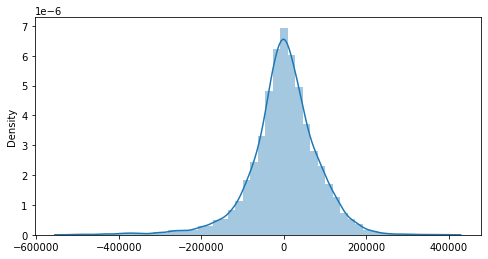

In [290]:
# visualizing residuals
fig = plt.figure(figsize=(8,4))
residuals = (y_test- y_pred_final)
sns.distplot(residuals)

Ensemble Learning -Bagging -RandomForestRegressor

In [196]:
from sklearn.ensemble import RandomForestRegressor

#Grid CV round1
param_test1 = {'n_estimators':[10,20,40,60,80,100,150,200]}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=100,min_samples_leaf=20,
                                                          max_depth=8,max_features='auto' ,random_state=10), 
                        param_grid = param_test1, scoring='neg_mean_squared_error',cv=10, verbose=1)

gsearch1.fit(X_train,y_train)

#get the best score and parameters
print(gsearch1.best_score_)
print(gsearch1.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  7.3min finished


-8017138025.032865
{'n_estimators': 150}


In [199]:
#Grid CV round2
param_test2 = {'max_depth':[3,5,7,9,11,13], 'min_samples_split':[50,70,90,110,130,150,170,190]}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 150, min_samples_leaf=20,
                                                           max_features='auto',oob_score=True, random_state=10),
                        param_grid = param_test2, scoring='neg_mean_squared_error',iid=False, cv=10, verbose=1)

gsearch2.fit(X_train,y_train)

#get the best score and parameters
print(gsearch2.best_score_)
print(gsearch2.best_params_)


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 77.7min finished
C:\Users\Administrateur\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


-7352528589.10351
{'max_depth': 13, 'min_samples_split': 50}


NameError: name 'RandomForestClassifier' is not defined

In [201]:
#validation data)
rf1 = RandomForestRegressor(n_estimators= 150, max_depth=13, min_samples_split=50,
                                  min_samples_leaf=20,max_features='auto' ,oob_score=True, random_state=10)
rf1.fit(X_train,y_train)
#
print (rf1.oob_score_)

0.686145432811083


In [301]:
rf_model_final = RandomForestRegressor(n_estimators= 150, max_depth=13 , min_samples_split=50,min_samples_leaf=20,
                                       max_features='auto', random_state=10)

rf_model_final.fit(X_train,y_train)
y_pred_rf_final = rf_model_final.predict(X_test)

print("model R2 score: %.3f" % rf_model_final.score(X_test, y_test))
MSE_rf_test = mean_squared_error(y_test, y_pred_rf_final)
print('model Random Forest MSE is: ', MSE_rf_test)

model R2 score: 0.688
model Random Forest MSE is:  7262022960.978384


In [303]:
#score collector

score_collector=score_collector.append({'Model':'RandomForestRegressor','R2':rf_model_final.score(X_test, y_test),'MSE':MSE_rf_test}, ignore_index=True)

score_collector

,Model,R2,MSE
0,LinearRegression,0.533473,1.084968e+10
1,XGBRegressor,0.700380,6.968046e+09
2,RandomForestRegressor,0.687739,7.262023e+09


# Deep Learning neural network model

Split data in train, validation and test data

In [220]:
X = np.asarray(X).astype('float32')

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
    
print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(61224, 13)
(36734, 13)
(12245, 13)
(12245, 13)


In [221]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [274]:
# Build neuron model
model_dl = Sequential() 
model_dl.add(layers.Dense(64, activation='relu',input_shape=(X_train.shape[1],))) 
model_dl.add(layers.Dense(64, activation='relu'))
model_dl.add(layers.Dense(64, activation='relu'))
model_dl.add(layers.Dense(1))

model_dl.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________


In [275]:
# Adam optimiser MAE loss，mean absolute error)
model_dl.compile(optimizer='Adam', loss='mse', metrics=['mae'])

#fit
model_dl.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
             epochs=500, batch_size=128, verbose=1)


Epoch 1/500
287/287 [==============================] - 0s 1ms/step - loss: 36474077184.0000 - mae: 142951.2656 - val_loss: 14845579264.0000 - val_mae: 96032.9141
Epoch 2/500
287/287 [==============================] - 0s 995us/step - loss: 14657851392.0000 - mae: 95330.1484 - val_loss: 14610323456.0000 - val_mae: 95214.5859
Epoch 3/500
287/287 [==============================] - 0s 997us/step - loss: 14414210048.0000 - mae: 94416.3359 - val_loss: 14415974400.0000 - val_mae: 94236.7578
Epoch 4/500
287/287 [==============================] - 0s 984us/step - loss: 14219745280.0000 - mae: 93683.1172 - val_loss: 14128530432.0000 - val_mae: 93333.6406
Epoch 5/500
287/287 [==============================] - 0s 1ms/step - loss: 13950060544.0000 - mae: 92686.5156 - val_loss: 13803705344.0000 - val_mae: 91952.2422
Epoch 6/500
287/287 [==============================] - 0s 1ms/step - loss: 13614542848.0000 - mae: 91558.3125 - val_loss: 13374921728.0000 - val_mae: 90540.3359
Epoch 7/500
287/287 [======

287/287 [==============================] - 0s 952us/step - loss: 9768346624.0000 - mae: 74372.8359 - val_loss: 9586931712.0000 - val_mae: 74355.0781
Epoch 52/500
287/287 [==============================] - 0s 1ms/step - loss: 9738439680.0000 - mae: 74122.4141 - val_loss: 9644236800.0000 - val_mae: 74857.9766
Epoch 53/500
287/287 [==============================] - 0s 965us/step - loss: 9701471232.0000 - mae: 74031.7969 - val_loss: 9508467712.0000 - val_mae: 73630.9766
Epoch 54/500
287/287 [==============================] - 0s 979us/step - loss: 9736043520.0000 - mae: 74176.7031 - val_loss: 9503383552.0000 - val_mae: 73325.3984
Epoch 55/500
287/287 [==============================] - 0s 1ms/step - loss: 9691322368.0000 - mae: 73860.9062 - val_loss: 9572718592.0000 - val_mae: 73533.1797
Epoch 56/500
287/287 [==============================] - 0s 984us/step - loss: 9685011456.0000 - mae: 73862.5078 - val_loss: 9861858304.0000 - val_mae: 74513.2109
Epoch 57/500
287/287 [=======================

Epoch 102/500
287/287 [==============================] - 0s 985us/step - loss: 9392196608.0000 - mae: 72415.6172 - val_loss: 9379880960.0000 - val_mae: 72536.6094
Epoch 103/500
287/287 [==============================] - 0s 947us/step - loss: 9448941568.0000 - mae: 72755.1953 - val_loss: 9274144768.0000 - val_mae: 72236.8281
Epoch 104/500
287/287 [==============================] - 0s 951us/step - loss: 9468491776.0000 - mae: 72631.0391 - val_loss: 9271200768.0000 - val_mae: 72052.1719
Epoch 105/500
287/287 [==============================] - 0s 1ms/step - loss: 9458905088.0000 - mae: 72654.3047 - val_loss: 9208779776.0000 - val_mae: 72132.5078
Epoch 106/500
287/287 [==============================] - 0s 1ms/step - loss: 9460420608.0000 - mae: 72812.5000 - val_loss: 9469310976.0000 - val_mae: 72849.9453
Epoch 107/500
287/287 [==============================] - 0s 1ms/step - loss: 9431464960.0000 - mae: 72618.0078 - val_loss: 9391951872.0000 - val_mae: 73486.1875
Epoch 108/500
287/287 [=====

287/287 [==============================] - 0s 968us/step - loss: 9287673856.0000 - mae: 71799.6719 - val_loss: 9086991360.0000 - val_mae: 71214.4453
Epoch 153/500
287/287 [==============================] - 0s 983us/step - loss: 9284971520.0000 - mae: 71772.5000 - val_loss: 9116828672.0000 - val_mae: 71075.1484
Epoch 154/500
287/287 [==============================] - 0s 972us/step - loss: 9160679424.0000 - mae: 71321.0625 - val_loss: 9483165696.0000 - val_mae: 72799.6719
Epoch 155/500
287/287 [==============================] - 0s 970us/step - loss: 9258584064.0000 - mae: 71727.0234 - val_loss: 9376984064.0000 - val_mae: 72636.5000
Epoch 156/500
287/287 [==============================] - 0s 956us/step - loss: 9174361088.0000 - mae: 71387.5938 - val_loss: 9276113920.0000 - val_mae: 72121.7422
Epoch 157/500
287/287 [==============================] - 0s 973us/step - loss: 9199446016.0000 - mae: 71485.1797 - val_loss: 9088512000.0000 - val_mae: 71609.5781
Epoch 158/500
287/287 [=============

287/287 [==============================] - 0s 1ms/step - loss: 9053313024.0000 - mae: 70745.5859 - val_loss: 8897842176.0000 - val_mae: 70297.9844
Epoch 203/500
287/287 [==============================] - 0s 954us/step - loss: 9028448256.0000 - mae: 70672.4297 - val_loss: 9427035136.0000 - val_mae: 73182.3281
Epoch 204/500
287/287 [==============================] - 0s 956us/step - loss: 9043867648.0000 - mae: 70767.2969 - val_loss: 9023715328.0000 - val_mae: 71224.2109
Epoch 205/500
287/287 [==============================] - 0s 1ms/step - loss: 9120935936.0000 - mae: 71141.5859 - val_loss: 9146017792.0000 - val_mae: 71368.7266
Epoch 206/500
287/287 [==============================] - 0s 939us/step - loss: 9023620096.0000 - mae: 70624.1562 - val_loss: 9100919808.0000 - val_mae: 72088.1250
Epoch 207/500
287/287 [==============================] - 0s 1ms/step - loss: 9005922304.0000 - mae: 70522.0547 - val_loss: 9102187520.0000 - val_mae: 71906.1250
Epoch 208/500
287/287 [===================

287/287 [==============================] - 0s 962us/step - loss: 8927664128.0000 - mae: 70232.5859 - val_loss: 8834271232.0000 - val_mae: 70385.5859
Epoch 253/500
287/287 [==============================] - 0s 966us/step - loss: 8943562752.0000 - mae: 70220.4297 - val_loss: 9022210048.0000 - val_mae: 71054.4531
Epoch 254/500
287/287 [==============================] - 0s 969us/step - loss: 8900339712.0000 - mae: 70070.4844 - val_loss: 8804994048.0000 - val_mae: 69908.5547
Epoch 255/500
287/287 [==============================] - 0s 948us/step - loss: 8957047808.0000 - mae: 70382.1719 - val_loss: 9391287296.0000 - val_mae: 72669.2656
Epoch 256/500
287/287 [==============================] - 0s 1ms/step - loss: 8903915520.0000 - mae: 69986.2344 - val_loss: 9133401088.0000 - val_mae: 71495.2109
Epoch 257/500
287/287 [==============================] - 0s 1ms/step - loss: 8927460352.0000 - mae: 70108.4375 - val_loss: 9219933184.0000 - val_mae: 72490.5078
Epoch 258/500
287/287 [=================

Epoch 303/500
287/287 [==============================] - 0s 999us/step - loss: 8914996224.0000 - mae: 70119.3750 - val_loss: 8887488512.0000 - val_mae: 70742.2188
Epoch 304/500
287/287 [==============================] - 0s 1ms/step - loss: 8837916672.0000 - mae: 69729.7188 - val_loss: 8762788864.0000 - val_mae: 69981.2422
Epoch 305/500
287/287 [==============================] - 0s 1ms/step - loss: 8776513536.0000 - mae: 69434.2969 - val_loss: 8969465856.0000 - val_mae: 71051.1406
Epoch 306/500
287/287 [==============================] - 0s 1ms/step - loss: 8797664256.0000 - mae: 69520.0000 - val_loss: 8815122432.0000 - val_mae: 69968.8125
Epoch 307/500
287/287 [==============================] - 0s 923us/step - loss: 8828466176.0000 - mae: 69541.2734 - val_loss: 8732075008.0000 - val_mae: 69396.9531
Epoch 308/500
287/287 [==============================] - 0s 944us/step - loss: 8779019264.0000 - mae: 69345.1875 - val_loss: 8738042880.0000 - val_mae: 69364.0000
Epoch 309/500
287/287 [=====

287/287 [==============================] - 0s 1ms/step - loss: 8690358272.0000 - mae: 68983.6484 - val_loss: 8605199360.0000 - val_mae: 68789.8203
Epoch 354/500
287/287 [==============================] - 0s 1ms/step - loss: 8674032640.0000 - mae: 68939.4922 - val_loss: 8696603648.0000 - val_mae: 69430.8516
Epoch 355/500
287/287 [==============================] - 0s 978us/step - loss: 8700911616.0000 - mae: 68976.9688 - val_loss: 8630086656.0000 - val_mae: 69434.6641
Epoch 356/500
287/287 [==============================] - 0s 990us/step - loss: 8709714944.0000 - mae: 69018.2422 - val_loss: 8651716608.0000 - val_mae: 69152.6406
Epoch 357/500
287/287 [==============================] - 0s 961us/step - loss: 8650871808.0000 - mae: 68699.8047 - val_loss: 8693280768.0000 - val_mae: 69331.7109
Epoch 358/500
287/287 [==============================] - 0s 1ms/step - loss: 8638306304.0000 - mae: 68704.9062 - val_loss: 8735312896.0000 - val_mae: 68799.9141
Epoch 359/500
287/287 [===================

287/287 [==============================] - 0s 1ms/step - loss: 8616905728.0000 - mae: 68735.9688 - val_loss: 8602024960.0000 - val_mae: 68402.4141
Epoch 404/500
287/287 [==============================] - 0s 969us/step - loss: 8537662976.0000 - mae: 68176.9609 - val_loss: 8543028736.0000 - val_mae: 67880.1406
Epoch 405/500
287/287 [==============================] - 0s 1ms/step - loss: 8563607552.0000 - mae: 68412.7812 - val_loss: 8519393792.0000 - val_mae: 68939.2188
Epoch 406/500
287/287 [==============================] - 0s 988us/step - loss: 8573490688.0000 - mae: 68398.6719 - val_loss: 9100813312.0000 - val_mae: 71941.7266
Epoch 407/500
287/287 [==============================] - 0s 997us/step - loss: 8600953856.0000 - mae: 68608.0469 - val_loss: 8871825408.0000 - val_mae: 69996.1094
Epoch 408/500
287/287 [==============================] - 0s 977us/step - loss: 8592276480.0000 - mae: 68502.7969 - val_loss: 8547424768.0000 - val_mae: 68372.0156
Epoch 409/500
287/287 [=================

287/287 [==============================] - 0s 975us/step - loss: 8451514880.0000 - mae: 67911.4844 - val_loss: 8410414080.0000 - val_mae: 67505.4297
Epoch 454/500
287/287 [==============================] - 0s 1ms/step - loss: 8438655488.0000 - mae: 67741.0625 - val_loss: 8427926528.0000 - val_mae: 67519.8828
Epoch 455/500
287/287 [==============================] - 0s 1ms/step - loss: 8453961216.0000 - mae: 67814.8828 - val_loss: 8543932416.0000 - val_mae: 68597.1250
Epoch 456/500
287/287 [==============================] - 0s 1ms/step - loss: 8470721024.0000 - mae: 67861.7578 - val_loss: 8498371072.0000 - val_mae: 68190.6484
Epoch 457/500
287/287 [==============================] - 0s 960us/step - loss: 8479093760.0000 - mae: 67889.4141 - val_loss: 8613797888.0000 - val_mae: 68775.1562
Epoch 458/500
287/287 [==============================] - 0s 971us/step - loss: 8418891264.0000 - mae: 67652.0703 - val_loss: 8385389056.0000 - val_mae: 67773.1250
Epoch 459/500
287/287 [===================

Text(0, 0.5, 'Metric')

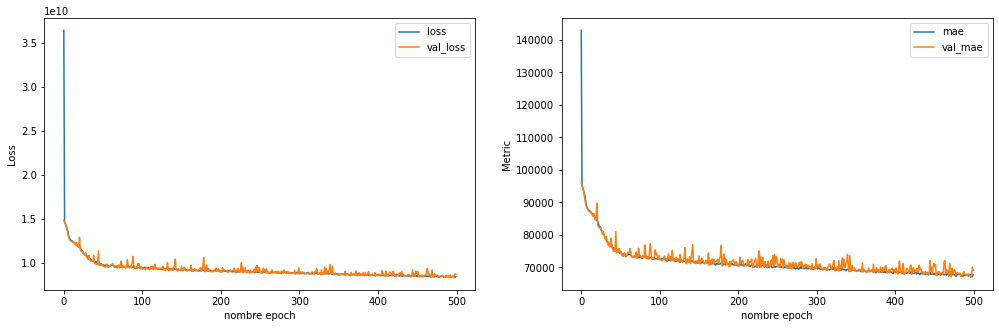

In [304]:
#history curve
history_df = pd.DataFrame(model_dl.history.history) 


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5) , gridspec_kw={'hspace': 0.5})

history_df.loc[:,['loss','val_loss']].plot(ax=ax1)
ax1.set_xlabel('nombre epoch')
ax1.set_ylabel('Loss')

history_df.loc[:,['mae','val_mae']].plot(ax=ax2)
ax2.set_xlabel('nombre epoch')
ax2.set_ylabel('Metric')

In [306]:
y_pred = model_dl.predict(X_test)
from sklearn import metrics
from sklearn.metrics import r2_score

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))


MAE: 68228.49841606268
MSE: 8659530583.37168
RMSE: 93056.59881691185
R2: 0.6276478172552586


In [307]:
#score collector

score_collector=score_collector.append({'Model':'Neural network','R2':metrics.r2_score(y_test, y_pred),
                                        'MSE':metrics.mean_squared_error(y_test, y_pred)}, ignore_index=True)

score_collector

,Model,R2,MSE
0,LinearRegression,0.533473,1.084968e+10
1,XGBRegressor,0.700380,6.968046e+09
2,RandomForestRegressor,0.687739,7.262023e+09
3,Neural network,0.627648,8.659531e+09
